In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_kmean"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [5]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 44071 abstracts from 19 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...


In [4]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [ ]:
# Embed all abstracts in batches

texts = df["clean_abs"].astype(str).tolist()
batch_size = 256

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=len(batch)
    )
    embeddings.append(batch_emb)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)


Embedding abstracts: 100%|██████████| 173/173 [04:09<00:00,  1.44s/it]

Embedding matrix shape: (44071, 768)


In [6]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


NameError: name 'embeddings' is not defined

In [7]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [8]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [9]:
# K-Means clustering on UMAP coordinates

k = 20 
kmeans = KMeans(n_clusters=k, random_state=42)

kmeans_labels = kmeans.fit_predict(umap_coords)
df["kmeans_cluster"] = kmeans_labels

print(f"K-Means clusters: {df['kmeans_cluster'].nunique()}")
df["kmeans_cluster"].value_counts().sort_index()


K-Means clusters: 20


kmeans_cluster
0     2301
1     1761
2     2762
3     2532
4     3014
5      759
6     2516
7     3270
8     1250
9     2073
10    1589
11    1940
12    1617
13    1851
14    2626
15    2035
16    3722
17    2217
18    2204
19    2032
Name: count, dtype: int64

In [10]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_clusters.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with clusters to: {out_path}")

Saved dataset with clusters to: ../../data/processed/abstracts/umap_kmean/abstracts_with_clusters.csv


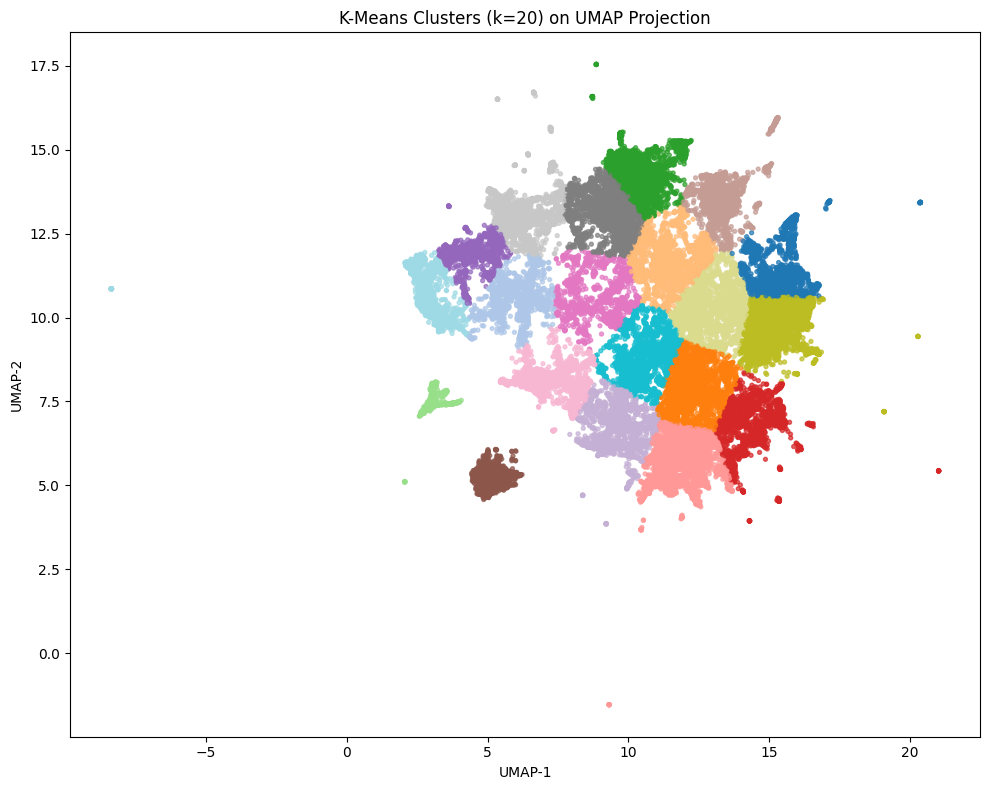

In [ ]:
# Plot K-Means clusters on UMAP projection

plt.figure(figsize=(10,8))
plt.scatter(
    df["umap_x"], df["umap_y"],
    c=df["kmeans_cluster"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title(f"K-Means Clusters (k={k}) on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [13]:
# Query distribution per K-Means cluster
kmeans_query_summary = (
    df.groupby(["kmeans_cluster", "query_id"])
      .size()
      .reset_index(name="count")
      .sort_values(["kmeans_cluster", "count"], ascending=[True, False])
)

kmeans_query_summary.head(30)


,kmeans_cluster,query_id,count
6,0,ml_predictive_maintenance,810
15,0,ml_rul,400
3,0,ml_manufacturing,362
11,0,ml_production_optimization,256
2,0,ml_inservice_monitoring,195
4,0,ml_planning_production,103
0,0,ml_anomaly_detection_production,65
7,0,ml_process_control,47
9,0,ml_product_design,13
13,0,ml_remanufacturing,8


In [15]:
cols = ["kmeans_cluster", "query_id", "title", "clean_abs"]

reps = []
for cid in range(k):
    idxs = df[df["kmeans_cluster"] == cid].index
    emb_sub = embeddings[idxs]
    centroid = embeddings[df["kmeans_cluster"] == cid].mean(axis=0, keepdims=True)
    sims = cosine_similarity(emb_sub, centroid).flatten()
    rep_idx = idxs[sims.argmax()]
    reps.append(df.loc[rep_idx, cols])

pd.DataFrame(reps)


,kmeans_cluster,query_id,title,clean_abs
25659,0,ml_predictive_maintenance,Prediction of motor failure time using an arti...,"© 2019 by the authors. Licensee MDPI, Basel, S..."
33947,1,ml_production_optimization,Optimization-Based Comparative Study of Machin...,Copyright © 2025 Kaleem Ullah et al. Internati...
8141,2,ml_manufacturing,Empowering the Factory of the Future: Integrat...,"© 2025 selection and editorial matter, C. Kish..."
16820,3,ml_manufacturing,Machine Learning as a Smart Manufacturing Tool,"© 2020, Springer Nature Singapore Pte Ltd.In s..."
4445,4,ml_manufacturing,Intelligent laser-based metal additive manufac...,", under exclusive licence to Springer-Verlag L..."
24451,5,ml_predictive_maintenance,Optimizing Battery RUL Prediction of Lithium-I...,© 2013 IEEE.Predictive Maintenance (PdM) of li...
22116,6,ml_predictive_maintenance,A Survey on the Applications of Cloud Computin...,© 2025 by the authors.The convergence of cloud...
5627,7,ml_manufacturing,AI Adoption Across Industries,"© 2026 Kanchan Naithani, Shrikant Tiwari and S..."
32852,8,ml_production_optimization,AI-enhanced bioprocess technologies: machine l...,", under exclusive licence to Springer Nature B..."
5717,9,ml_manufacturing,The Transformative Role of ML Algorithms in Su...,", under exclusive license to Springer Nature S..."
